# Fundus Retinal Vessel Segmentation

- Jakub Rapsiewicz
- Paweł Woźniak

## Auxiliary Functions

Auxiliary functions are used by all 3 methods of segmenting fundus vessels, so their definition is at the very beginning. Below are also the global constants used throughout the notebook, these mainly relate to loading and saving data.

In [2]:
DATA_DIR = "data"
GOLD_STANDARD_DIR = "manual1" 
FOV_DIR = "mask"
IMAGE_DIR = "images"
RESULTS_DIR = "results"

### Data operations

The following functions implement a mechanism for loading fundus images, field-of-view images, and gold standard masks from the **HSF** collection. This simplifies the code by focusing only on "sample names" (`sample_name`), which in our collection consists of a sample number and a code denoting the type of eye: (`h` - healthy, `dr` - diabetic retinopathy, `g` - glaucomatous eyes).

In [3]:
from pathlib import Path
from typing import List
import cv2

def load_image(sample_name: str):
    sample_dir = Path(DATA_DIR) / Path(IMAGE_DIR)

    for ext in [ '.jpg', '.JPG' ]:
        sample = sample_dir / Path(sample_name + ext)
        if sample.is_file: 
            return cv2.cvtColor(cv2.imread(str(sample)), cv2.COLOR_BGR2RGB)

    raise FileNotFoundError

def load_fov(sample_name: str):
    sample_dir = Path(DATA_DIR) / Path(FOV_DIR)

    sample = sample_dir / Path(sample_name + '_mask.tif')
    if not sample.is_file:
        raise FileNotFoundError

    return cv2.imread(str(sample), cv2.IMREAD_GRAYSCALE)

def load_gold_standard(sample_name: str):
    sample_dir = Path(DATA_DIR) / Path(GOLD_STANDARD_DIR)

    sample = sample_dir / Path(sample_name + '.tif')
    if not sample.is_file:
        raise FileNotFoundError

    # load image in grayscale
    return cv2.imread(str(sample), cv2.IMREAD_GRAYSCALE)

def load_sample_data(sample_name: str):
    image = load_image(sample_name)
    gold_standard = load_gold_standard(sample_name)
    fov_mask = load_fov(sample_name)
    
    return (image, gold_standard, fov_mask)

def get_all_sample_names() -> List[str]:
    """ Return list of strings - names of given samples. We can get from names to images, fovs, and gold_standards """
    
    # Use files from Gold Standards, because they have basic names + tif extension
    samples_dir = Path(DATA_DIR) / Path(GOLD_STANDARD_DIR)

    # data/manual1/01_dr.tif -> 01_dr
    sample_names = [ sample_file.stem for sample_file in samples_dir.iterdir() ] 
    return sample_names
    


### Statistical functions

In order to compare the classification parameters of the algorithms, we use the implemented confusion matrix calculation (`confusion_matrix`) from the `sklearn.metrics` package. On the basis of the 4 obtained binary classification parameters (T/F), we calculate:
- _accuracy_ 
- _sensitivity_ 
- _specificity_
- the average of specificity and sensitivity -> `mean(sense, spec)`.
- geometric mean from specificity and sensitivity -> `geo_mean(sense, spec)`.

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def geo_mean_overflow(iterable):
    return np.exp(np.log(iterable).mean())

def calculate_mask_statistics(gold_standard, mask, fov):
    # Assume vmin = 0, vmax = 255, type = uint8t
    assert gold_standard.shape == mask.shape

    fov_flat = fov.flatten()
    cm = confusion_matrix(
        gold_standard.flatten()[fov_flat==255], 
        mask.flatten()[fov_flat==255]
    )
    tn, fp, fn, tp = cm.ravel()

    cm_accuracy = tp / (tp + fp)
    cm_specificity = tn / (tn + fp)
    cm_sensitivity = tp / (tp + fn)
    
    cm_mean = (cm_specificity + cm_sensitivity) / 2
    cm_geo = geo_mean_overflow([cm_specificity, cm_sensitivity]) 

    return (cm_accuracy, cm_specificity, cm_sensitivity, cm_mean, cm_geo)

def print_statistics(gold_standard, mask):
    acc, spec, sens, mean_spec_sens, geo_spec_sens = calculate_mask_statistics(gold_standard, mask)

    print(f"Accuracy: {acc * 100:.2f}%")
    print(f"Sensitivity: {spec * 100:.2f}%")
    print(f"Specificity: {sens * 100:.2f}%")
    print(f"Mean(spec, sens): {mean_spec_sens * 100:.2f}%")
    print(f"GeoMean(spec, sens): {geo_spec_sens * 100:.2f}%")

### Benchmark

Functions in this category are used to aggregate and summarize results for multiple images simultaneously. Each segmentation method implements its own `Solver` class, which has a `generate_mask` method.
Thus, we use a single function to summarize the results of each algorithm. The results are saved in the folder `results/<name>` where `name` stands for the name of the algorithm, respectively:

- `rf` -> Ridge Filtering, a solver for solving with the help of filters and image operations
- `ml` -> Machine Learning, a solver for classical machine learning
- `dl` -> Deep Learning, a solver for deep neural networks

In [69]:
from tqdm import tqdm
from typing import Tuple
import csv

def _get_algorithm_result_path(sample_name, algorithm_name) -> Path:
    return Path(RESULTS_DIR) / algorithm_name / f"{sample_name}_mask.png"

def fetch_algorithm_result(sample_name, algorithm_name):
    path = _get_algorithm_result_path(sample_name, algorithm_name)
    if path.exists:
        return cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    else:
        return None
    
def save_algorihtm_result(sample_name, algorithm_name, result):
    dirpath = Path(RESULTS_DIR) / algorithm_name
    dirpath.mkdir(parents=True, exist_ok=True)

    path = _get_algorithm_result_path(sample_name, algorithm_name)
    cv2.imwrite(str(path), result)
    # load image in grayscale

def benchmark_method(benchmark_sample_names, algorithm, force: bool = False) -> List[Tuple[str, np.ndarray, np.ndarray]]:
    """Return triplets (sample_name, gold_standard, generated_mask)"""

    results = []
    for sample_name in tqdm(benchmark_sample_names):
        image, gs, fov = load_sample_data(sample_name)
        
        result = fetch_algorithm_result(sample_name, str(algorithm))
        
        if result is None or force:

            result = algorithm.generate_mask(
                image=image,
                fov=fov, 
            )
            save_algorihtm_result(sample_name, str(algorithm), result)

        results.append((sample_name, gs, result))
    return results
    
def calculate_mean_mask_statistics(results: List[Tuple[str, np.ndarray, np.ndarray]]) -> List:
    rows = []
    for name, gs, mask in results:
        fov = load_fov(name)
        row = list(calculate_mask_statistics(gs, mask, fov))
        rows.append(row)

    data = np.array(rows, np.float32)
    mean_data = np.average(data, axis=0)
    return mean_data.tolist()


def _acquire_results_rows(results: List[Tuple[str, np.ndarray, np.ndarray]]):
    headers = ["Name", "Accuracy", "Sensitivity", "Specificity", "Mean(spec,sens)", "GeoMean(spec,sens)"]
    rows = [ headers ]
    for name, gs, mask in results:
        fov = load_fov(name)
        stats = calculate_mask_statistics(gs, mask, fov)
        row = [ name ] + [ f"{x * 100:.2f}" for x in stats ]
        rows.append(row)
    return rows

def export_results_to_csv(results: List[Tuple[str, np.ndarray, np.ndarray]], method_name: str):
    rows = _acquire_results_rows(results)

    filename = method_name + '.csv'
    print(f"Exporting results stats to '{filename}' file...")
    with open(filename, 'w', newline='') as outfile:
        writer = csv.writer(outfile, delimiter=';')
        writer.writerows(rows)

def pretty_print_results(results: List[Tuple[str, np.ndarray, np.ndarray]], method_name: str):
    rows = _acquire_results_rows(results)

    print(f"Statistics for '{method_name}' method:")
    print("----------------------------")
    col_maxes = [ max(len(x) for x in col) for col in zip(*rows) ]
    print('\n'.join([' | '.join([f"{cell}".rjust(col_maxes[i]) for i, cell in enumerate(row)]) for row in rows]))


### PLoT Functions

The following functions simplify the creation of comparison plots by providing ready-made templates for presenting results. For example, the function `plt_compare_two_images` is used to compare the expert mask with the one generated by the algorithm.

In [6]:
import matplotlib.pyplot as plt 
import numpy as np
from typing import Tuple

plt.rcParams['figure.figsize'] = (14, 7)

def plt_show_channels(r, g, b):
    plt.subplot(131)
    plt.title("Red channel")
    plt.imshow(r, cmap='gray', vmin=0, vmax=255)

    plt.subplot(132)
    plt.title("Green channel")
    plt.imshow(g, cmap='gray', vmin=0, vmax=255)

    plt.subplot(133)
    plt.title("Blue channel")
    plt.imshow(b, cmap='gray', vmin=0, vmax=255)

def plt_show_sample(image, gold_standard, fov_mask):
    plt.subplot(131)
    plt.title("Retinal Fundus")
    plt.imshow(image)

    plt.subplot(132)
    plt.title("Gold standard")
    plt.imshow(gold_standard, cmap='gray', vmin=0, vmax=255)

    plt.subplot(133)
    plt.title("Fov Mask")
    plt.imshow(fov_mask, cmap='gray', vmin=0, vmax=255)

def plt_compare_two_images(image1, image2, title1 = None, title2 = None, grayscale = False):
    cmap = 'gray' if grayscale else 'viridis'
    plt.subplot(121)
    if title1 is not None: 
        plt.title(title1)
    plt.imshow(image1, cmap=cmap)
    plt.subplot(122)
    if title2 is not None:
        plt.title(title2)
    plt.imshow(image2, cmap=cmap)
    
def plt_show_benchmark_results(results: List[Tuple[str, np.ndarray, np.ndarray]]):
    """ Plot two rows for benchmark results. Upper row are generated masks, lower row are gold standards. """
    # results is a triple of (name, gs, mask)

    gold_standards = []
    masks = []
    sample_names = []
    for name, gs, mask in results:
        gold_standards.append(gs)
        masks.append(mask)
        sample_names.append(name)
        
    n = len(results)

    for i, mask in enumerate(masks):
        plt.subplot(2, n, i + 1)
        plt.title(f"Mask[{sample_names[i]}]")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(mask, cmap='gray')

    for i, gs in enumerate(gold_standards): 
        plt.subplot(2, n, n + i + 1)
        plt.title(f"Gold Standard [{sample_names[i]}]")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(gs, cmap='gray')

def plt_show_benchmark_stats(results: List[Tuple[str, np.ndarray, np.ndarray]], method_title: str):
    """ """
    
    mean_stats = calculate_mean_mask_statistics(results)

    stats = ("Accuracy", "Sensitivity", "Specificity", "Mean(spec, sens)", "GeoMean(spec, sens)")

    solver_means = {
        method_title: tuple(round(100 * stat, 2) for stat in mean_stats),
    }

    x = np.arange(len(stats))  # the label locations
    width = 0.5  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    ax.grid(axis='y')

    for attribute, measurement in solver_means.items():
        offset = width * multiplier
        rects = ax.bar(x, measurement, width, label=attribute)
        ax.bar_label(rects, padding=2)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Wartość statystyki [%]')
    ax.set_title(f'Wyniki na zbiorze benchmark za pomocą {method_title}')
    ax.set_xticks(x + width, stats)

    ax.legend(loc='upper left', 
              # ncols=3
              )
    ax.set_ylim(0, 110)

    plt.show()

def print_benchmark_stats(results: List[Tuple[str, np.ndarray, np.ndarray]], method_title: str):
    print(f"Stats for {method_title}")
    headers = ["Sample Name", "Accuracy", "Sensitivity", "Specificity", "Mean(spec, sens)", "GeoMean(spec, sens)"]

    rows = [ headers ]
    for name, gs, mask in results:
        fov = load_fov(name)
        stats = calculate_mask_statistics(gs, mask, fov)
        row = [ name ] + [ f"{x * 100:.2f}" for x in stats ]
        rows.append(row)
    
    lens = [ max(map(len, col) for col in zip(*rows)) ]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in rows ]
    print('\n'.join(table))

## Methods Description

This section includes a presentation of all three methods we used: _Ridge Filtering_, _Machine Learning_ and _Deep Learning_. All three methods have been adapted to handle a data format consistent with the **HFR** (_High Resolution Fundus_) dataset - this is the dataset we will be using in our comparison. The set of the last 5 images (from `14_g` to `15_h`) will serve as a test set (**benchmark**) on which we will compare all methods. In this chapter, all approaches are presented independently of each other, a summary is presented in the next chapter - at the end of the notebook.

In [14]:
sample_names = get_all_sample_names()
TRAIN_SAMPLE_NAMES = sample_names[:6] # example, any non-benchmark image can be used for training
BENCHMARK_SAMPLE_NAMES = sample_names[-5:] # reserved for benchmark, cannot be used in training
EXAMPLE_SAMPLE = sample_names[0] # used to showcase examples

print(f"{EXAMPLE_SAMPLE = }")
print(f"{TRAIN_SAMPLE_NAMES = }")
print(f"{BENCHMARK_SAMPLE_NAMES = }")

EXAMPLE_SAMPLE = '01_dr'
TRAIN_SAMPLE_NAMES = ['01_dr', '01_g', '01_h', '02_dr', '02_g', '02_h']
BENCHMARK_SAMPLE_NAMES = ['14_g', '14_h', '15_dr', '15_g', '15_h']


After loading all the sample images, we present the standard three from the HRF database - Photo, Gold Standard and FOV mask, allowing us to isolate the area of interest.

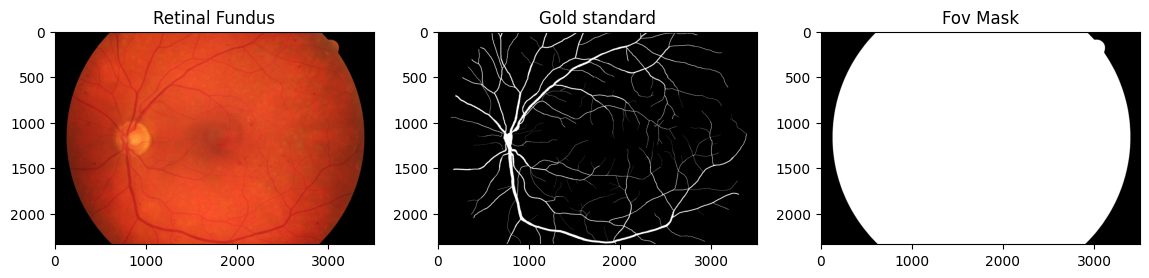

In [102]:
image, gs, fov = load_sample_data(EXAMPLE_SAMPLE)
plt_show_sample(image, gs, fov)

### 1. Ridge Filtering

This section deals with the application of **Ridge Filtering** methods to the binary classification of retinal fundus vessels. To solve this problem, we use preprocessing methods in the form of histogram normalization, processing in the form of _Sato_ filter, and postprocessing in the form of Gaussian blurring.

#### 1.1 Functions 

We use an implementation of the `sato` filter from the `skimage.filters` library. The other functions use methods from the `cv2` library. During the analysis, we noticed that the dominant factor in the quality of the classifier, is the selected color channel (`r`, `g`, `b`). The `combine_channels` function is designed to aggregate the results calculated for each channel using a weighted average to focus on the channels that convey the most information about the vessels. 

In [10]:
from skimage.filters import sato

def combine_channels(r, g, b, threshold: int, weights: List[float]):
    """ Merge 3-color channels into one using weighted sum. Return thresholded image. """
    assert sum(weights) <= 1.0

    result = np.average([r, g, b], weights=weights, axis=0)
    _, mask = cv2.threshold(result, threshold, 255, cv2.THRESH_BINARY)
    return mask
    
def ridge_detect_channel(channel: np.ndarray):
    """ Use sato filter. Make sure vessels are white on given image. """
    return sato(channel, black_ridges=False)
    
def preprocess_channel(channel: np.ndarray):
    image = cv2.equalizeHist(channel)
    image = cv2.bitwise_not(image)
    return image
    
def postprocess_channel(channel: np.ndarray, blur_kernel_size = 19):
    # assume: uint8
    return cv2.GaussianBlur(channel, (blur_kernel_size, blur_kernel_size), 0)

#### 1.2 Solver 

The `Solver` we implemented takes 3 main parameters:
- `threshold` -> an integer value in the range [`0`, `255`] used for channel aggregation.
- `channel_weights` -> array of weights, normalized to give a total value of `1.0` 
- `blur_kernel_size` -> kernel size used by `GaussianBlur`.

The `generate_mask` function shows the whole process of obtaining a classification mask based on the image and FOV mask. The whole process is described in more detail in the next section.

In [11]:
class RFSolver:
    def __init__(self, threshold: int, channel_weights: List[float], blur_kernel_size: int):
        self.threshold = threshold
        self.channel_weights = channel_weights 
        self.blur_kernel_size = blur_kernel_size 
    
    def __str__(self):
        return "rf"

    def generate_mask(self, image, fov): 
        """ Full image processing using only Ridge Filtering methods. Return binary classification mask """
        
        r, g, b = cv2.split(image)

        r_pre, g_pre, b_pre = map(preprocess_channel, (r, g, b))
        r_ridge, g_ridge, b_ridge = map(ridge_detect_channel, (r_pre, g_pre, b_pre))

        normalize = lambda x: (x - x.min()) / (x.max() - x.min()) * 255
        r_norm, g_norm, b_norm = map(normalize, (r_ridge, g_ridge, b_ridge))
        r_post, g_post, b_post = map(postprocess_channel, (r_norm, g_norm, b_norm), [ self.blur_kernel_size ] * 3) 

        mask = combine_channels(r_post, g_post, b_post, threshold=self.threshold, weights=self.channel_weights)

        return mask

#### 1.3 Processing

The section shows the effect of image processing with Ridge Filtering methods, step by step.

We can see that each color carries a different amount of information regarding the vessels in the retina. At first glance, the green channel is the most valuable source of information, immediately followed by the red channel and the blue channel at the very end. We use this information later when assigning weights to the channels.

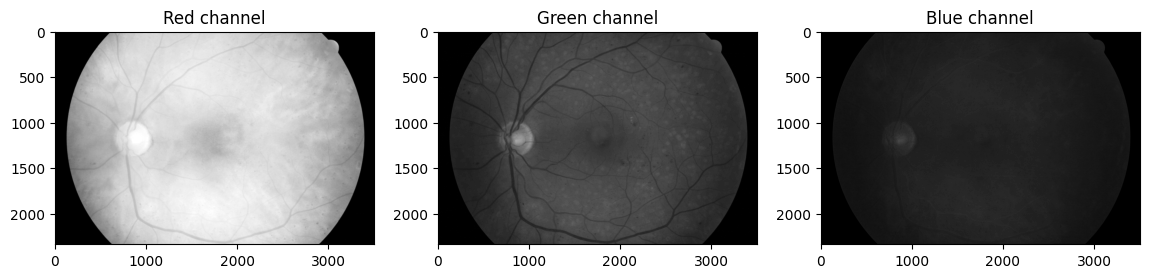

In [11]:
r, g, b = cv2.split(image)
plt_show_channels(r, g, b)

Each channel is preprocessed with histogram normalization and color inversion to operate on white vessels.

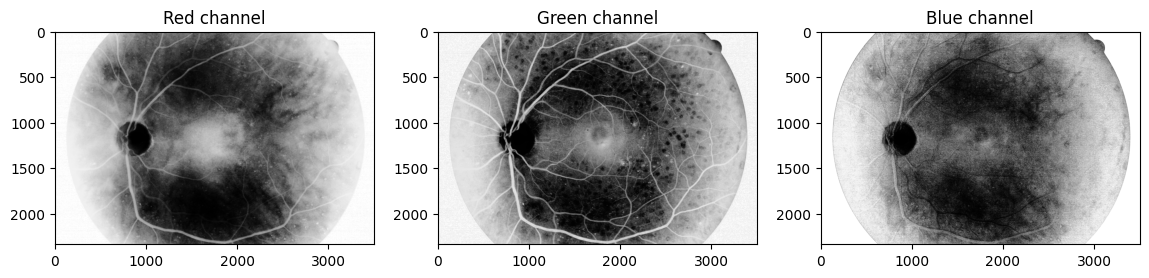

In [12]:
r_pre, g_pre, b_pre = map(preprocess_channel, (r, g, b))
plt_show_channels(r_pre, g_pre, b_pre)

For each channel we apply a `sato` filter. In our experiments, we also tried using the Frangi filter (`frangi`), but it gave inferior results.

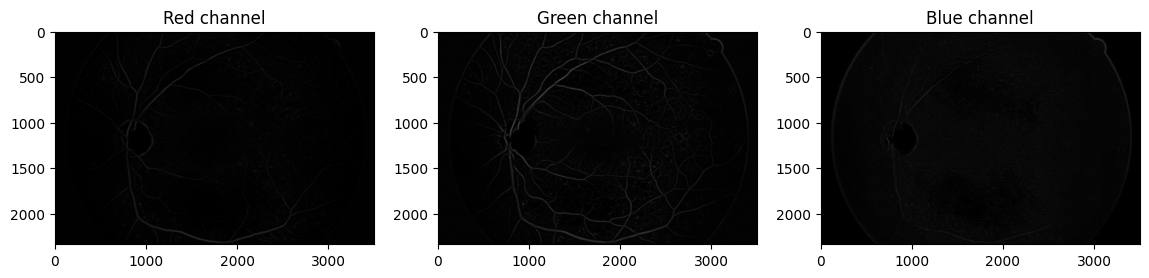

In [13]:
r_ridge, g_ridge, b_ridge = map(ridge_detect_channel, (r_pre, g_pre, b_pre))
plt_show_channels(r_ridge, g_ridge, b_ridge)

Due to the very dark effect of the filter, we apply normalization for each channel.

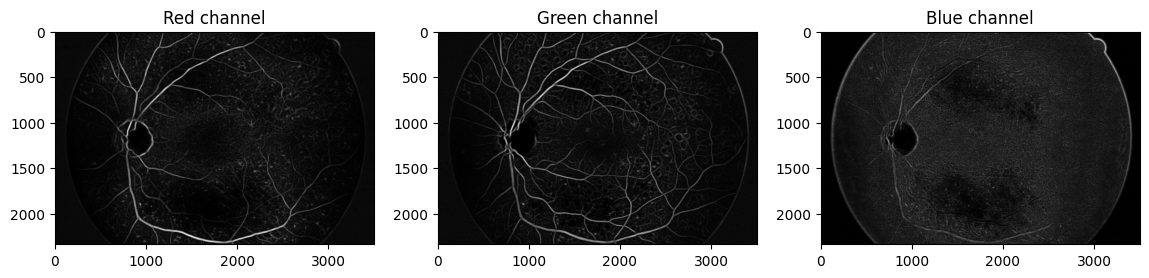

In [14]:
normalize = lambda x: (x - x.min()) / (x.max() - x.min()) * 255
r_norm, g_norm, b_norm = map(normalize, (r_ridge, g_ridge, b_ridge))
plt_show_channels(r_norm, g_norm, b_norm)

After applying the filter and normalizing, we can see many irregular shapes (circles) located around the dishes. Since these are small clusters of white pixels, we try to reduce their contribution to the resulting mask using Gaussian blur.

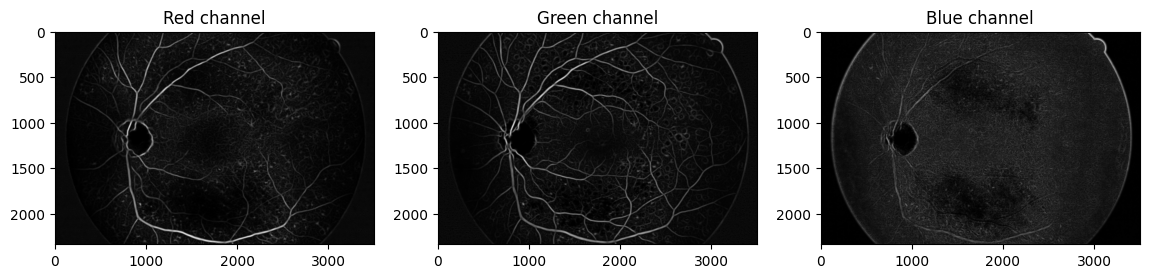

In [15]:
r_post, g_post, b_post = map(postprocess_channel, (r_norm, g_norm, b_norm), [ 11 ] * 3) 
plt_show_channels(r_post, g_post, b_post)

The resulting processed channels are combined using weights `0.3`, `0.7`, and `0` for the `r`, `g`, and `b` channels. The value `threshold=55` was chosen empirically to give the best results.

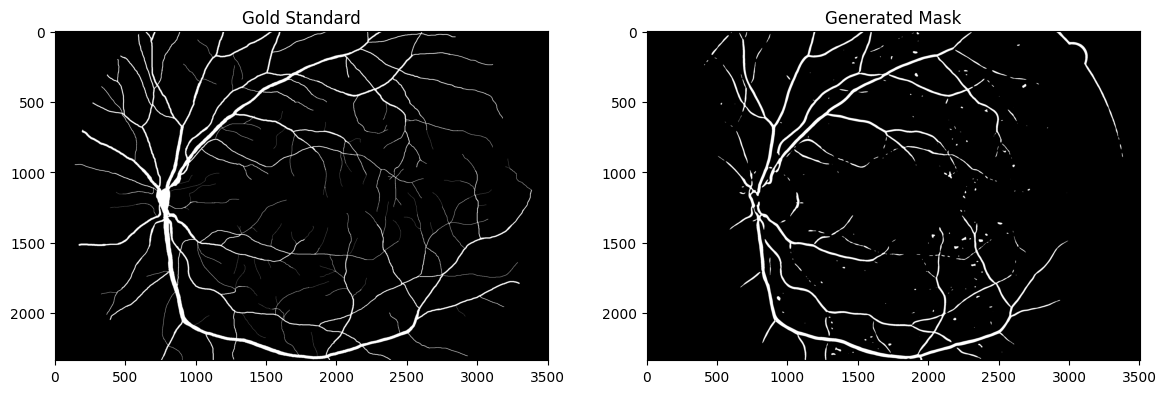

In [16]:
mask = combine_channels(
    r_post, g_post, b_post, 
    threshold=55, 
    weights=[0.3, 0.7, 0],
)

plt_compare_two_images(gs, mask, title1 = "Gold Standard", title2 = "Generated Mask", grayscale=True)

For the sample mask thus obtained, we calculate all the classification measures mentioned above and list them below.

In [17]:
print_statistics(gs, mask)

Accuracy: 66.00%
Sensitivity: 98.44%
Specificity: 56.67%
Mean(spec, sens): 77.55%
GeoMean(spec, sens): 74.69%


#### 1.4 Benchmark

Based on the selected parameters, we create a Ridge Filtering Solver and run it on our benchmark set.

In [34]:
rf_name = 'Ridge Filtering'
rf_solver = RFSolver(
    threshold=55, 
    channel_weights=[0.3, 0.7, 0], 
    blur_kernel_size=11
)

In [15]:
rf_results = benchmark_method(BENCHMARK_SAMPLE_NAMES, rf_solver, force=False)

100%|██████████| 5/5 [00:01<00:00,  3.39it/s]


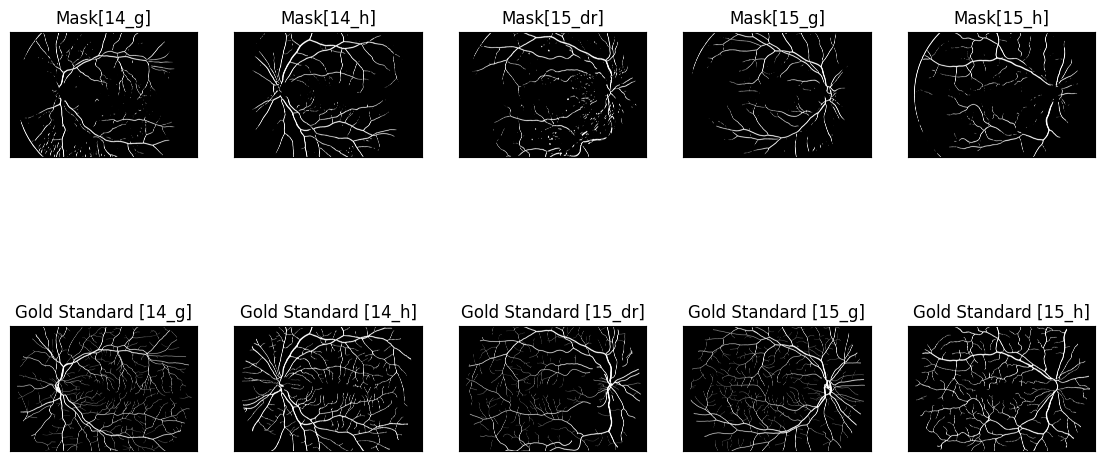

In [16]:
plt_show_benchmark_results(rf_results)

In [70]:
pretty_print_results(rf_results, rf_name)

Statistics for 'Ridge Filtering' method:
----------------------------
 Name | Accuracy | Sensitivity | Specificity | Mean(spec,sens) | GeoMean(spec,sens)
 14_g |    74.99 |       98.52 |       48.54 |           73.53 |              69.16
 14_h |    88.94 |       99.18 |       57.29 |           78.24 |              75.38
15_dr |    68.68 |       98.05 |       50.90 |           74.48 |              70.65
 15_g |    80.91 |       98.92 |       48.07 |           73.49 |              68.95
 15_h |    90.95 |       99.51 |       47.91 |           73.71 |              69.04


In [71]:
export_results_to_csv(rf_results, rf_name)

Exporting results stats to 'Ridge Filtering.csv' file...


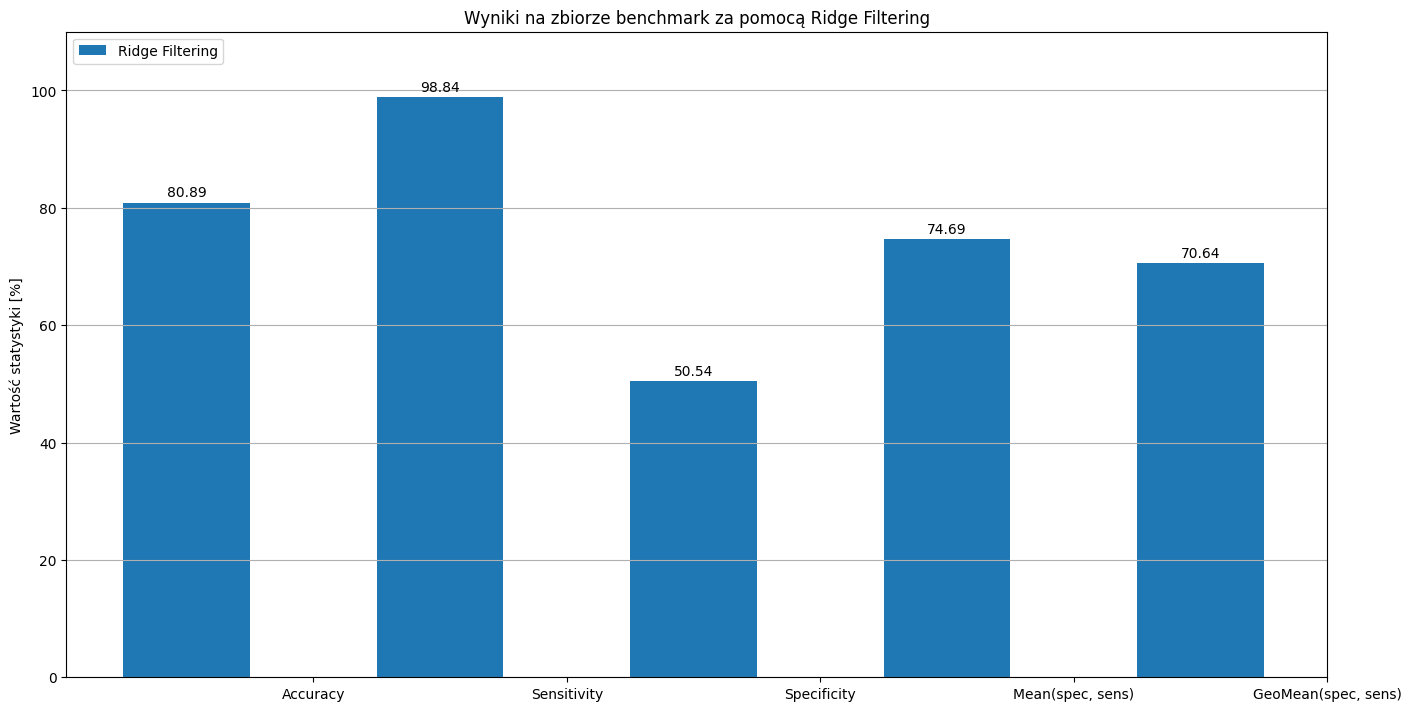

In [35]:
plt_show_benchmark_stats(rf_results, rf_name)

#### 1.5 Conclusions

The Ridge Filtering method presented here is a simple and uncomplicated method. Among its pluses is definitely the processing time, since the main time outlay here is the use of the `sato` filter. For its simplicity and speed, it presents really good measures at **75** for `accuracy` and the average of specificity and sensitivity. 

From the images, we can see that the main problem is the lack of ease in imaging the less distinct vessel fragments. Large vessel fragments were easily picked up by the filter, while the others in many cases were rejected by the cutoff (`threshold`). While the method reproduces the `character` of the vessels well, it lacks much detail to be effective.

### 2. Machine Learning

This section describes our  application of **Machine Learning** methods and in particular the `RandomForest` classifier to binary classification of retinal fundus vessels. We use `RandomSearchCV` to search for the best hyperparameters. For correct classification, the image is divided into slice sizes of 5x5 px. Each resulting slice forms a feature vector consisting of:

- mean value of the green channel
- standard deviation of the green color value
- Hu moments counted for the green channel

Since such processing for images from the HRF database is time-consuming, we use our own optimizations for drawing the training and test set. The method we used also aims to compensate for inequalities (**imbalance**) in the provided data, as we will show in the learning process.

#### 2.1. Functions

The functions shown below are used to divide an image into slices (`tile`) and obtain features from a given slice.

In [50]:
from skimage.measure import moments_central, moments_normalized, moments_hu

def generate_tile_centers(image, fov_mask, tile_size, step_size = 1):
    rows, cols, channels = image.shape
    # step_size = tile_size//2 if overlapping else tile_size 
    for row in range(tile_size//2, rows - tile_size//2, step_size):
        for col in range(tile_size//2, cols - tile_size//2, step_size):
            if fov_mask[row, col] == 0: # or 0 if not
                continue

            yield (row, col)
            
def extract_tile_features(image, center, tile_size):
    row, col = center

    row1 = row - tile_size//2
    row2 = row + tile_size//2 + 1
    col1 = col - tile_size//2
    col2 = col + tile_size//2 + 1
    green = image[row1:row2, col1:col2 , 1]

    green_avg = np.average(green) / 255
    green_std = np.std(green) / 255

    g = green.astype('float64')
    g /= 255
    mu = moments_central(g)
    nu = moments_normalized(mu)
    hu_moments = moments_hu(nu)

    # x = green.flatten()
    x = np.hstack((green_avg, green_std, hu_moments))
    
    return x

#### 2.2. Solver

The Machine Learning Solver we implemented presents the entire process of generating a classification mask for a given image having already learned the model. Since the provided images are of high resolution, the process is really time-consuming and can take up to an hour. The process is divided into 3 steps:
- Divide the provided image into slices
- Generate a feature vector `X` on the basis of the slice data
- Using classifier prediction, label the corresponding pixels in the mask

In [51]:
class MLSolver:
    def __init__(self, classifier, tile_size: int, step_size: int = 1):
        self.classifier = classifier
        self.tile_size = tile_size
        self.step_size = step_size
        
    def __str__(self):
        return "ml"
    
    # time consuming!
    def generate_mask(self, image, fov):
        centers = list(generate_tile_centers(
            image, fov, self.tile_size, self.step_size
        ))
        
        X = [ extract_tile_features(image, (row, col), self.tile_size) for (row, col) in centers ]
            
        mask = np.zeros_like(fov)
        y_pred = self.classifier.predict(X)
        for (row, col), decision in zip(centers, y_pred):
            if decision == 1: mask[row, col] = 255
                
        return mask

#### 2.3 Training the classifier

The whole process of learning a classifier is shown below. The first step is to create a training set. The function `generate_image_X_y` is responsible for generating features for a single fundus image. The optimization used is to first collect the coordinate of selected image slices (`tile`) and then select a sample (`random.sample`) without calling time-consuming functions to obtain features from the slice. In this way, we provide a solution to the imbalance of the obtained data. The `bulk_generate_X_y` function is responsible for collecting an equal number of data from each image.

In [108]:
import random

def generate_image_X_y(sample_name: str, tile_size: int, tiles_per_image: int, pos_neg_ratio: float, step_size: int):
    image, gs, fov = load_sample_data(sample_name)

    tile_centers = list(generate_tile_centers(
        image=image, fov_mask=fov,
        step_size=step_size, tile_size=tile_size
    ))
    positive_tile_centers = []
    negative_tile_centers = []

    for (row, col) in tile_centers:
        if gs[row, col] > 0:
            positive_tile_centers.append((row, col))
        else:
            negative_tile_centers.append((row, col))

    n_positive_tiles = int(tiles_per_image * pos_neg_ratio)
    n_negative_tiles = tiles_per_image - n_positive_tiles
    assert n_negative_tiles > 0 and n_positive_tiles > 0

    # proper imbalance handling - select random sample equal to given proportion between P and N
    pos_coords = random.sample(positive_tile_centers, n_positive_tiles)
    neg_coords = random.sample(negative_tile_centers, n_negative_tiles)

    test_coords = pos_coords + neg_coords
    random.shuffle(test_coords)
    
    X = []
    y = []
    for row, col in test_coords:
        x = extract_tile_features(
            image=image, center=(row, col), tile_size=tile_size
        )
        X.append(x)
        decision = 1 if gs[row, col] == 255 else 0 
        y.append(decision)
    return (X, y)
    
def bulk_generate_X_y(sample_names: List[str], tile_size: int, n_tiles_all: int, pos_neg_ratio: float, step_size: int):
    X = []
    y = []
    assert len(sample_names) > 0

    n_tiles_per_image = n_tiles_all // len(sample_names)
    n_tiles_mod = n_tiles_all % len(sample_names)

    for i, sample_name in enumerate(tqdm(sample_names)):
        # split samples in a way that they sum up to n_tiles_all
        # even if divides with reminder
        n_tiles = n_tiles_per_image + (1 if i < n_tiles_mod else 0)
        new_X, new_y = generate_image_X_y(sample_name, tile_size, n_tiles, pos_neg_ratio, step_size)
        X.extend(new_X)
        y.extend(new_y)
    return (X, y)

We call the implemented functions for the first 6 training images, wanting to get a feature vectoTraining the classifierr of length `100000`. Here we also use the parameter `pos_neg_ratio` which denotes the ratio between the `P` and `N` classes at `0.4`. The `tile_size` parameter sets our window size in pixels (`5x5`). By defining `step_size` we speed up the drawing process, since we do not go over all the pixels of the image.

In [109]:
n_train_images = 6
train_sample_names = TRAIN_SAMPLE_NAMES[:n_train_images]
n_train_tiles = 100000

X, y = bulk_generate_X_y(
    sample_names=train_sample_names, 
    tile_size=5,
    n_tiles_all=n_train_tiles,
    pos_neg_ratio=0.4,
    step_size=5
)
assert len(X) == n_train_tiles

100%|██████████| 6/6 [00:27<00:00,  4.52s/it]


As we can see, the classes remain balanced in a defined proportion.

In [110]:
from collections import Counter
print(f"Classes counts: {Counter(y)}")

Classes counts: Counter({0: 60004, 1: 39996})


In [111]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In order to search the hyperparameter space of the `RandomForest` classifier, we define a set of parameters and use the `RandomizedSearchCV` algorithm. The parameters shown below are the result of multiple tuning and are now chosen so that the classifier does not decide on an extreme value.

In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

clf = RandomForestClassifier()
parameters= { 
    'n_estimators': [500, 600],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [7,8,9,10,11],
    'criterion' :['gini', 'entropy']
}
random_src = RandomizedSearchCV(estimator=clf, param_distributions = parameters,
                               cv = 5, n_iter = 10, n_jobs=-1)

In [ ]:
random_src.fit(X_train, y_train)

In [115]:
print(f"{random_src.best_estimator_ = }")
print(f"{random_src.best_params_ = }")

random_src.best_estimator_ = RandomForestClassifier(criterion='entropy', max_depth=10, max_features='auto',
                       n_estimators=600)
random_src.best_params_ = {'n_estimators': 600, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'entropy'}


In [117]:
y_pred = random_src.predict(X_test) 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83     18034
           1       0.76      0.69      0.72     11966

    accuracy                           0.79     30000
   macro avg       0.78      0.77      0.78     30000
weighted avg       0.79      0.79      0.79     30000



We save the trained classifier to a file.

In [ ]:
import joblib
joblib.dump(random_src, 'random_search_cv.pkl')

#### 2.4 Benchmark

We test the trained classifier on a benchmark set.

In [54]:
import joblib
rnd_src = joblib.load("random_search_cv.pkl")
print(rnd_src.best_params_)
classifier = rnd_src.best_estimator_
print(classifier)

{'n_estimators': 600, 'max_features': 'log2', 'max_depth': 9, 'criterion': 'gini'}
RandomForestClassifier(max_depth=9, max_features='log2', n_estimators=600)


In [55]:
ml_solver = MLSolver(
    classifier=classifier,
    tile_size=5,
    step_size=1,
)
ml_name = 'Machine Learning'

In [56]:
ml_results = benchmark_method(BENCHMARK_SAMPLE_NAMES, ml_solver, force=False)

100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


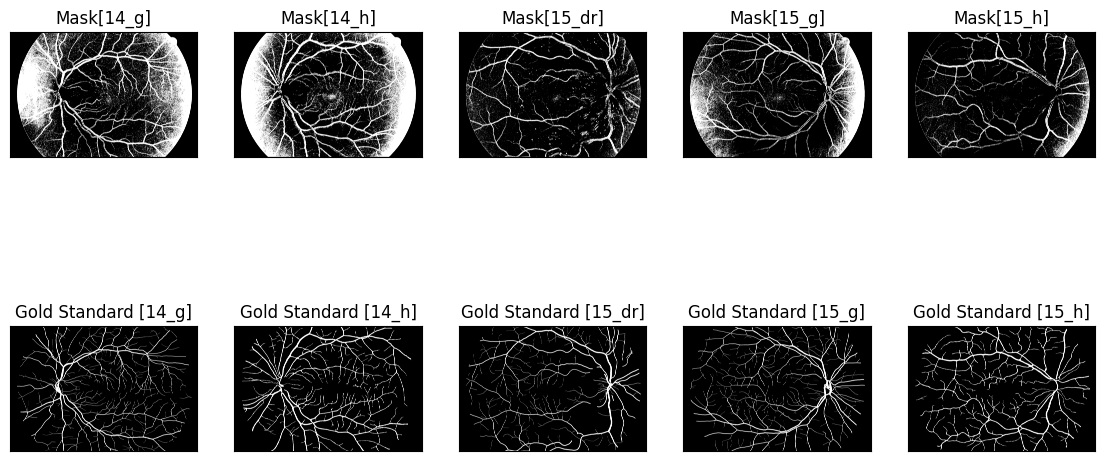

In [25]:
plt_show_benchmark_results(ml_results)

In [57]:
pretty_print_results(ml_results, ml_name)

Statistics for 'Machine Learning' method:
----------------------------
 Name | Accuracy | Sensitivity | Specificity | Mean(spec,sens) | GeoMean(spec,sens)
 14_g |    17.51 |       66.46 |       78.06 |           72.26 |              72.03
 14_h |    20.27 |       63.51 |       80.51 |           72.01 |              71.51
15_dr |    37.83 |       92.07 |       57.56 |           74.81 |              72.80
 15_g |    22.22 |       79.16 |       62.74 |           70.95 |              70.47
 15_h |    40.57 |       92.29 |       51.45 |           71.87 |              68.91


In [58]:
export_results_to_csv(ml_results, ml_name)

Exporting results stats to 'Machine Learning.csv' file...


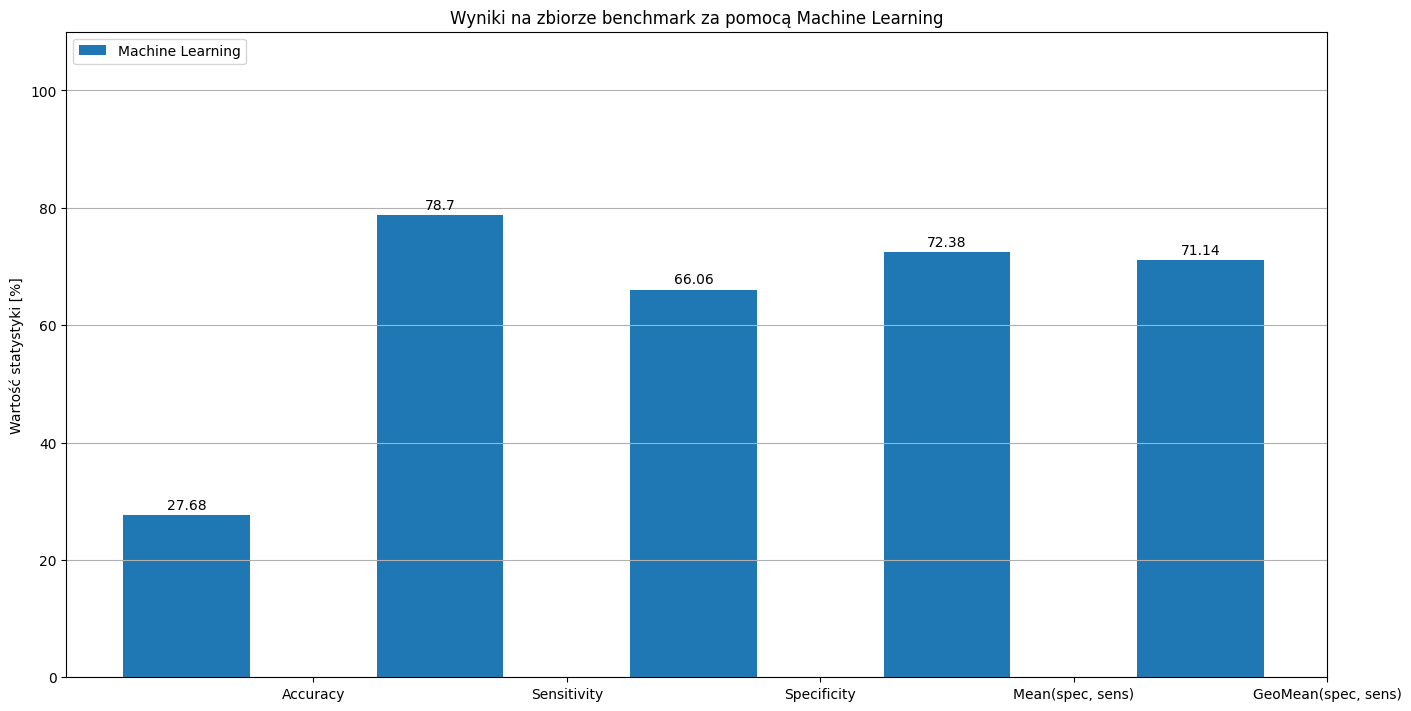

In [59]:
plt_show_benchmark_stats(ml_results, ml_name)

#### 2.5 Conclusions

The Machine Learning method used is very good at mapping both larger and smaller vessel fragments. The biggest drawback of this method is the low efficiency which may be due to a couple of problems:
- Lack of sufficient data -> on the generated masks, you can see large chunks of false assignment of the area as a vessel at the extreme points of the retina. 
- Uneven distribution -> An additional factor may be the result of accumulating most of the draw data in the central part of the eye, where it is much easier to distinguish the vessel from the background. 
- Lack of adequate preprocessing -> In the accompanying images, you can see large "spots" / light effects located in the right and left parts of the retina, which can significantly impede correct identification based on the color channel. 

Observing a decrease in prediction quality at the periphery of the eye compared to the center, we suspect that this is due to more differences in vascular structure at the border of the eye.

An additional problem is the long processing time. Since our classification is done on a pixel-per-pixel basis, we have to go through all the pixels of the image, and generate features for each of them. This is a time-consuming process that results in generation times of 40 minutes for a single image.

### 3. Deep Learning

This section deals with the application of **Deep Learning** methods and, in particular, _U-nets_ to the binary classification of retinal fundus vessels. To solve this problem, we use the methods implemented in the `keras` library.

#### 3.1 Functions

The following are function implementations designed to playback and convert an image into chunks for processing by the rest of the `keras` library functions. Their implementation was necessary due to problems with the `kutils` library.

In [60]:
import keras
from keras_unet.metrics import iou
import cv2
import numpy as np

PATCH_SIZE = 256
PATCH_STRIDE = 64

def get_patches(img, size, stride):
    org_img_size = img.shape[1:4]

    i_max = (org_img_size[0] // stride) + 1 - (size // stride)
    j_max = (org_img_size[1] // stride) + 1 - (size // stride)

    patches = np.zeros((i_max * j_max, size, size, org_img_size[2]))

    k = 0
    for i in range(i_max):
        for j in range(j_max):
            patches[k] = img[ 0, i * stride : i * stride + size, j * stride : j * stride + size, : ]
            k += 1
    
    return patches

def reconstruct(img, org_img_size, size, stride, average=False):
    pp = np.zeros(org_img_size)

    i_max = (org_img_size[0] // stride) + 1 - (size // stride)
    j_max = (org_img_size[1] // stride) + 1 - (size // stride)

    if average:
        mask = np.zeros_like(pp)

    kk = 0
    for i in range(i_max):
        for j in range(j_max):
            pp[ i * stride : i * stride + size, j * stride : j * stride + size ] += img[kk, :, :, :]

            if average:
                mask[ i * stride : i * stride + size, j * stride : j * stride + size ] += 1

            kk += 1
    
    if average:
        mask[mask == 0] = 1
        pp /= mask
    
    return pp

def threshold(img, t):
    nimg = np.zeros_like(img)

    nimg[img < t] = 0
    nimg[img >= t] = 1

    return nimg

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


#### 3.2 Solver

As with the other methods, we create a `Solver` adapted to generate a mask based on the provided photo. The entire process is covered in depth in the following sections.

In [61]:
class DLSolver:
    def __init__(self, model, patch_size: int, patch_stride: int, threshold: float, blur_kernel_size: int):
        self.model = model
        self.patch_size = patch_size
        self.patch_stride = patch_stride
        self.threshold = threshold
        self.blur_kernel_size = blur_kernel_size

        assert self.threshold <= 1.0
        
    def __str__(self):
        return "dl"
    
    def generate_mask(self, image, fov):
        xx = np.array([image], dtype=np.float32)
        x_test = get_patches(
            xx,
            size=self.patch_size,
            stride=self.patch_stride
        )
        y_pred = self.model.predict(x_test)
        pp = reconstruct(y_pred, xx.shape[1:4], size=self.patch_size, stride=self.patch_stride, average=True)
        pb = cv2.blur(pp, (self.blur_kernel_size, self.blur_kernel_size))
        
        mask_float = cv2.threshold(pb, self.threshold, 1.0, cv2.THRESH_BINARY)[1]
        # select one of three channels, convert [0.,1.] -> [0, 255]
        mask = (mask_float * 255).astype(np.uint8)[:, :, 0]
        return mask


#### 3.3 Model Training

Training of the model, due to its time-consuming nature, took place on the Google Collab platform.

In [49]:
import keras_unet.utils as kutils
import numpy as np
import matplotlib.pyplot as plt
import keras


PATCH_SIZE = 256
PATCH_STRIDE = 128

def get_batch_names(sample_names, num_batches):
    return np.array_split(sample_names, num_batches)

def get_batch_data(sample_names, val_sample_names, patch_size=PATCH_SIZE, patch_stride=PATCH_STRIDE):
    x_train = kutils.get_patches(
        np.array([load_image(path) for path in sample_names], dtype=np.float32),
        size=patch_size,
        stride=patch_stride
    )
    y_train = kutils.get_patches(
        np.expand_dims(np.array([load_gold_standard(path) for path in sample_names], dtype=np.float32), -1),
        size=patch_size,
        stride=patch_stride
    )
    x_val = kutils.get_patches(
        np.array([load_image(path) for path in val_sample_names], dtype=np.float32),
        size=patch_size,
        stride=patch_stride
    )
    y_val = kutils.get_patches(
        np.expand_dims(np.array([load_gold_standard(path) for path in val_sample_names], dtype=np.float32), -1),
        size=patch_size,
        stride=patch_stride
    )

    x_train /= 255
    y_train /= 255
    x_val /= 255
    y_val /= 255
    
    return x_train, y_train, x_val, y_val


In [ ]:
# from sklearn.model_selection import train_test_split
# x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=0)
# x_len = x_train.shape[0] + x_val.shape[0]
# train_data = kutils.get_augmented(x_train, y_train)

In [ ]:
from keras_unet.models import custom_unet
from keras_unet.metrics import iou, iou_thresholded
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.optimizers import SGD
import os

x_train = kutils.get_patches(
    np.array([load_image(path) for path in ['01_dr']]),
    size=PATCH_SIZE,
    stride=PATCH_STRIDE
)

model = custom_unet(input_shape=x_train[0].shape)

checkpoint_callback = ModelCheckpoint(
    'fundus_segm_v1.h5',
    monitor='val_loss',
    save_best_only=True
)

if os.path.exists("model_history_log.csv"):
    os.remove("model_history_log.csv")

csv_logger = CSVLogger("model_history_log.csv", append=True)

model.compile(
    SGD(learning_rate=0.01),
    "binary_crossentropy",
    metrics=[iou]
)

In [ ]:
# model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  432         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
import gc

batch_size = 16

sample_names = list(filter(lambda x: '0' in x and '9' not in x, get_all_sample_names()))
val_sample_names = list(filter(lambda x: '09' in x, get_all_sample_names()))

for i in range(4):
    print('real epoch', i, 'starts here.')
    for batch_names in get_batch_names(sample_names, 9):
        gc.collect()
        
        x_train, y_train, x_val, y_val = get_batch_data(batch_names, val_sample_names)

        # train_data = kutils.get_augmented(x_train, y_train)

        # model.fit_generator(
        #     train_data,
        #     steps_per_epoch=2,
        #     epochs = 1,
        #     validation_data=(x_val, y_val),
        #     callbacks=[checkpoint_callback, csv_logger]
        # )

        model.fit(
            x_train,
            y_train,
            batch_size = 64,
            epochs = 1,
            validation_data=(x_val, y_val),
            callbacks=[checkpoint_callback, csv_logger]
        )

        del x_train
        del y_train
        del x_val
        del y_val

model.save('fundus_segm_v1_final.h5')

real epoch 0 starts here.
14/14 [==============================] - 16s 1s/step - loss: 0.0913 - iou: 0.5518 - val_loss: 0.0737 - val_iou: 0.5432
real epoch 1 starts here.
14/14 [==============================] - 16s 1s/step - loss: 0.1192 - iou: 0.4959 - val_loss: 0.0797 - val_iou: 0.5390


KeyboardInterrupt: ignored

#### 3.4 Processing

The following shows the process of selecting the postprocessing parameters of the obtained images from the trained model. Observing the resulting mask for different cutoff values of `threshold`, we select the final value of `0.8`.

(1, 2336, 3504, 3) (1683, 256, 256, 3)
53/53 [==============================] - 168s 3s/step
(1683, 256, 256, 3) (1683, 256, 256, 1)


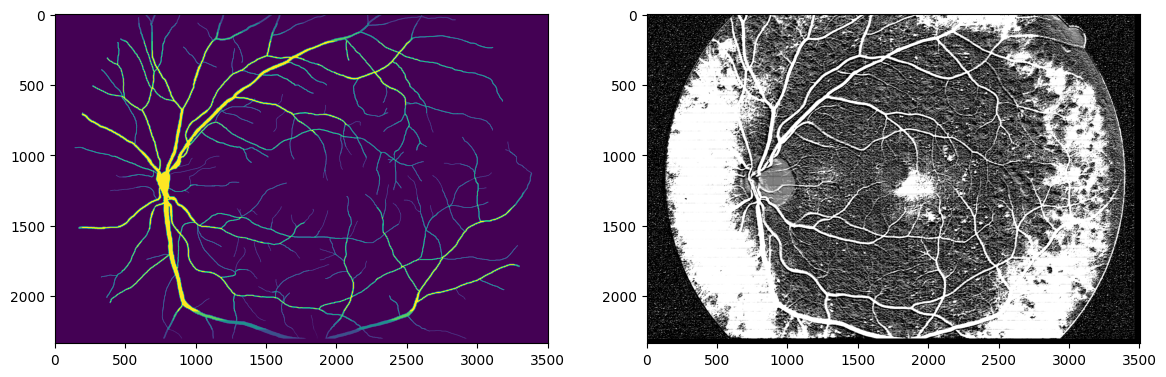

In [118]:
model = keras.models.load_model('fundus_segm_v1.h5', custom_objects={'iou': iou})

xx = np.array([load_image(EXAMPLE_SAMPLE)], dtype=np.float32)
x_test = get_patches(
    xx,
    size=PATCH_SIZE,
    stride=PATCH_STRIDE
)

yy = np.expand_dims(np.array([load_gold_standard(EXAMPLE_SAMPLE)], dtype=np.float32), -1)
y_test = get_patches(
    yy,
    size=PATCH_SIZE,
    stride=PATCH_STRIDE
)

print(xx.shape, x_test.shape)
y_pred = model.predict(x_test)
print(x_test.shape, y_pred.shape)
pp = reconstruct(y_pred, xx.shape[1:4], size=PATCH_SIZE, stride=PATCH_STRIDE, average=True)

plt.subplot(121)
plt.imshow(reconstruct(y_test, yy.shape[1:4], size=PATCH_SIZE, stride=PATCH_STRIDE).squeeze())
plt.subplot(122)
plt.imshow(pp)

(array([12147279.,   163866.,   846138.,    99366.,   103989.,   203850.,
          137172.,   962970.,   232686.,  9658716.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

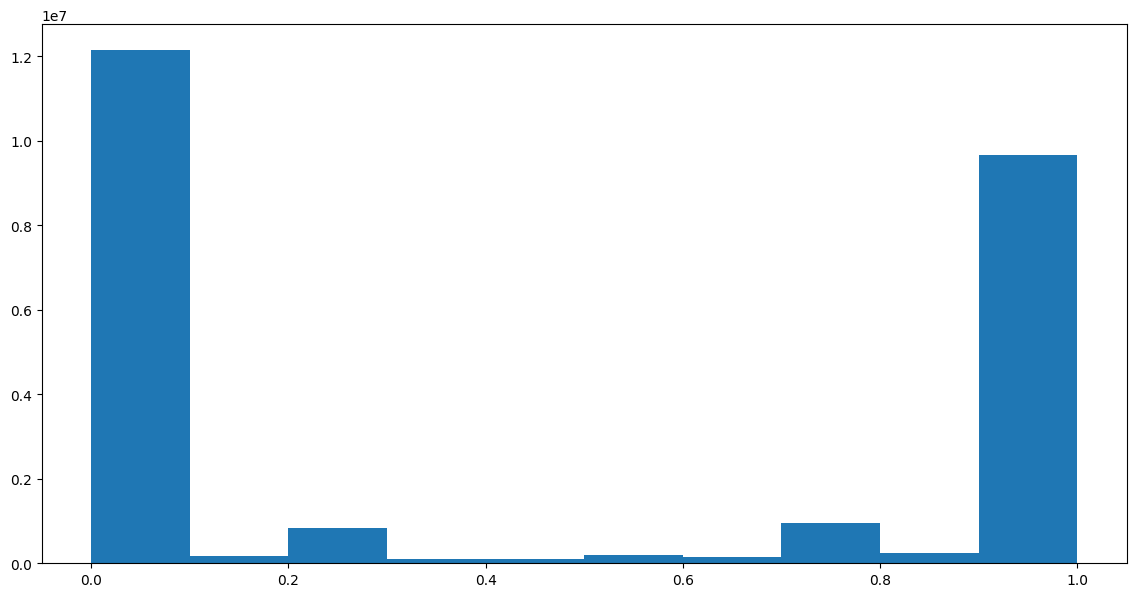

In [119]:
plt.hist(pp.flatten())

In [120]:
pb = cv2.blur(pp, (8, 8))

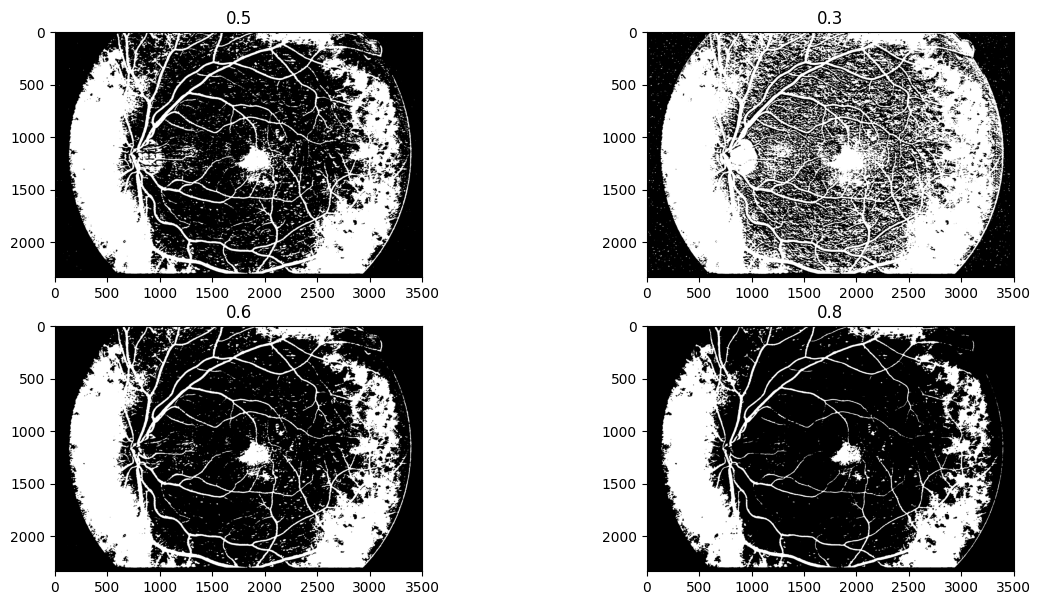

In [121]:
plt.subplot(221)
plt.title('0.5')
plt.imshow(cv2.threshold(pb, 0.5, 1.0, cv2.THRESH_BINARY)[1])
plt.subplot(222)
plt.title('0.3')
plt.imshow(cv2.threshold(pb, 0.3, 1.0, cv2.THRESH_BINARY)[1])
plt.subplot(223)
plt.title('0.6')
plt.imshow(cv2.threshold(pb, 0.6, 1.0, cv2.THRESH_BINARY)[1])
plt.subplot(224)
plt.title('0.8')
plt.imshow(cv2.threshold(pb, 0.8, 1.0, cv2.THRESH_BINARY)[1])

#### 3.5 Benchmark

In [62]:
dl_solver = DLSolver(
    model=keras.models.load_model('fundus_segm_v1.h5', custom_objects={'iou': iou}),
    patch_size=PATCH_SIZE,
    patch_stride=PATCH_STRIDE,
    threshold=0.85,
    blur_kernel_size=8
)
dl_name = "Deep Learning"

In [63]:
dl_results = benchmark_method(BENCHMARK_SAMPLE_NAMES, dl_solver, force=False)

100%|██████████| 5/5 [00:01<00:00,  2.98it/s]


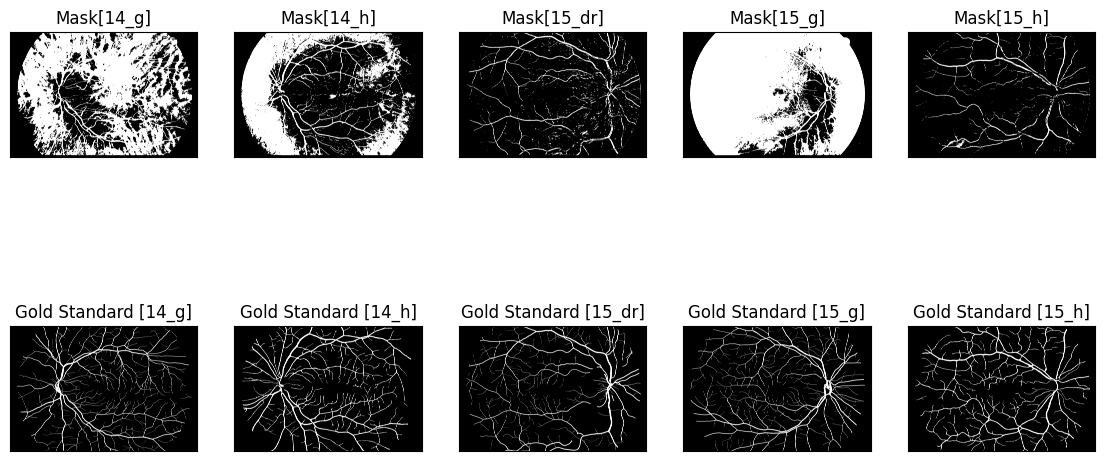

In [64]:
plt_show_benchmark_results(dl_results)

In [65]:
pretty_print_results(dl_results, dl_name)

Statistics for 'Deep Learning' method:
----------------------------
 Name | Accuracy | Sensitivity | Specificity | Mean(spec,sens) | GeoMean(spec,sens)
 14_g |    12.07 |       40.19 |       90.03 |           65.11 |              60.15
 14_h |    20.95 |       63.49 |       83.97 |           73.73 |              73.02
15_dr |    59.19 |       96.50 |       60.50 |           78.50 |              76.41
 15_g |     9.85 |       17.63 |       94.84 |           56.23 |              40.89
 15_h |    79.36 |       98.70 |       48.82 |           73.76 |              69.42


In [66]:
export_results_to_csv(dl_results, dl_name)

Exporting results stats to 'Deep Learning.csv' file...


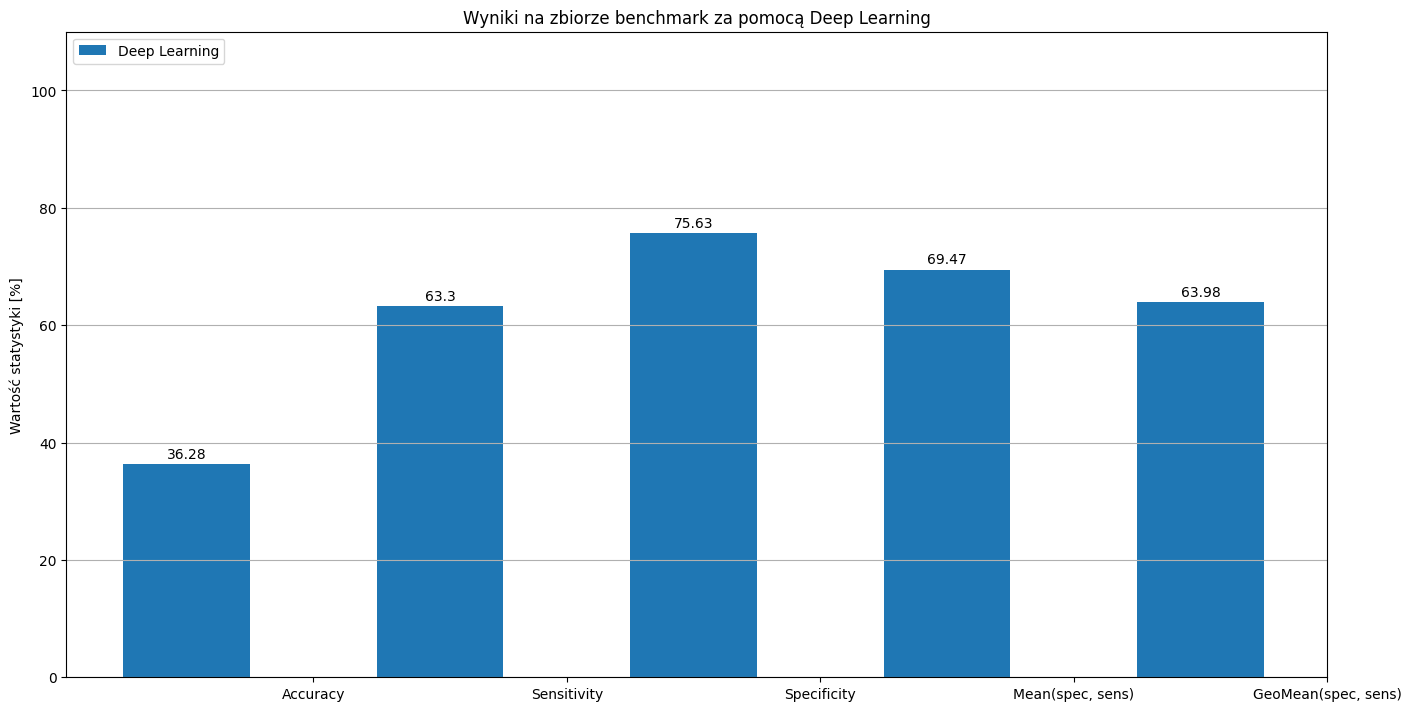

In [68]:
plt_show_benchmark_stats(dl_results, dl_name)

#### 3.6 Conclusions

The UNet network we used, is theoretically the best method to solve the vessel segmentation problem. Unfortunately, training the model is time-consuming, making tuning hyperparameters a tedious task. 

In our examples above, you can see both very good and very bad examples of classification. (The `15_dr` and `15_g` samples are good examples of this). 

Additional steps that would need to be taken to improve model performance would be:
- Better matching of the `threshold` value -> In our case, this was an empirically selected value based on a couple of examples
- Data augmentation -> Probably would have improved the results, but it would have been difficult to implement in our case and would have increased the training time.
- Better customization of hyperparameters -> In our implementation we basically use default values


## Final Results Comparison

In this segment, we present a summary of the results for all the methods used.

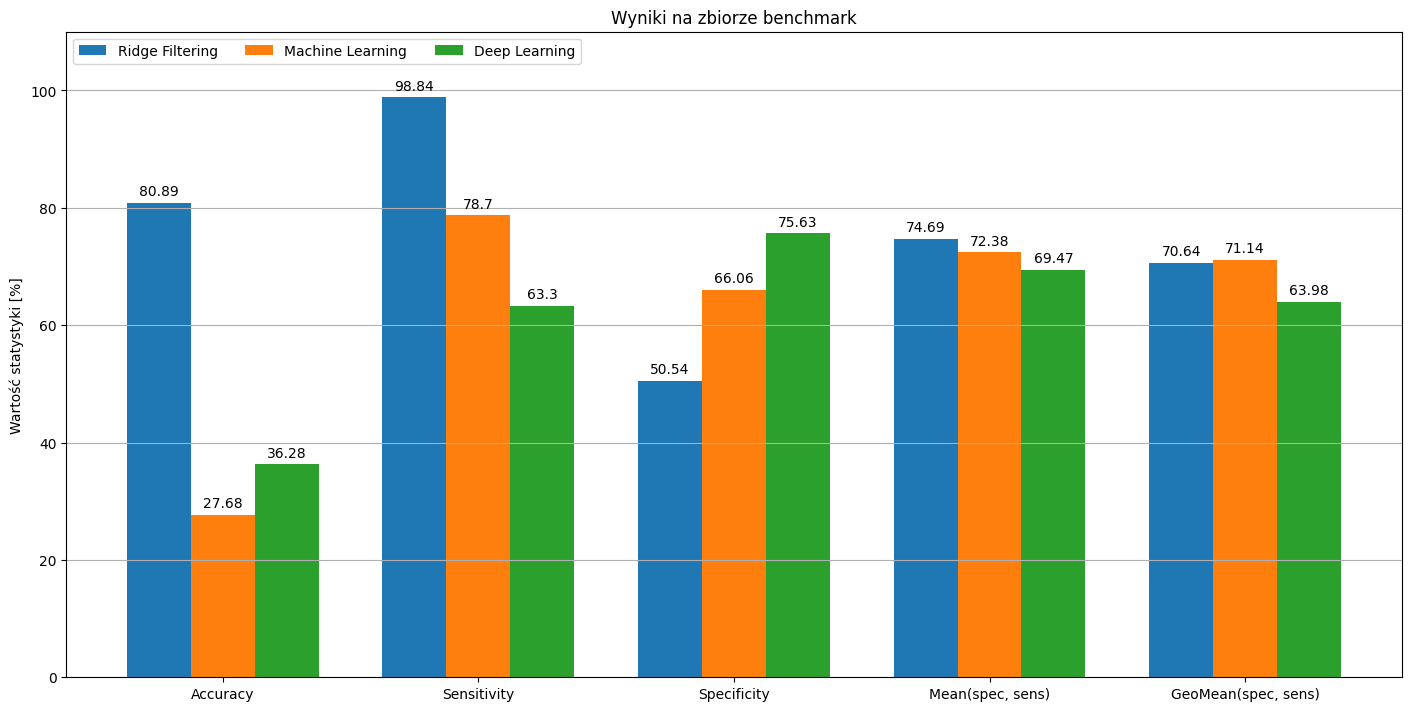

In [38]:
stats = ("Accuracy", "Sensitivity", "Specificity", "Mean(spec, sens)", "GeoMean(spec, sens)")

rf_stats, ml_stats, dl_stats = map(calculate_mean_mask_statistics, [rf_results, ml_results, dl_results]) 

solver_means = {
    "Ridge Filtering": tuple(round(100 * stat, 2) for stat in rf_stats),
    "Machine Learning": tuple(round(100 * stat, 2) for stat in ml_stats),
    "Deep Learning": tuple(round(100 * stat, 2) for stat in dl_stats),
}

x = np.arange(len(stats))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

ax.grid(axis='y')

for attribute, measurement in solver_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Wartość statystyki [%]')
ax.set_title(f'Wyniki na zbiorze benchmark')
ax.set_xticks(x + width, stats)

ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 110)

plt.show()


Observing the graph, we can see that each method achieves similar results of average sensitivity and specificity (`Mean(spec, sense)` and `GeoMean(spec, snes)`). 

We see a correlation in the measures of `sensitivity` and `specificity`. More advanced methods "prefer" `specificity` at the expense of lower measures of `sensitivity`.